In [1]:
import sys, os
sys.path.insert(0, '/Users/livestorborg/Desktop/FYS-STK4155/project2/code')

import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn_torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from src.neural_network import NeuralNetwork
from src.activations import Sigmoid, ReLU, Softmax
from src.losses import CrossEntropy
from src.optimizers import Adam
from src.training import train
from src.metrics import accuracy
from src.plotting import lambda_eta_heatmap

## Parameters

In [2]:
TEST_SIZE = 0.2
EPOCHS = 20
BATCH_SIZE = 64
HIDDEN_LAYERS = [64]  # List of hidden layer sizes
PATIENCE = 5

LOGREG_MAX_ITER = 500
LOGREG_SOLVER = 'lbfgs'

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Load and prepare MNIST dataset

In [3]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')

X = mnist.data
y = mnist.target.astype(int)  # Convert to integers


# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=SEED
)

# Scale pixel values to [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Optionally standardize (zero mean, unit variance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# One-hot encode labels for neural network
def one_hot_encode(y, n_classes=10):
    n_samples = len(y)
    y_encoded = np.zeros((n_samples, n_classes))
    y_encoded[np.arange(n_samples), y] = 1
    return y_encoded

y_train_encoded = one_hot_encode(y_train)
y_test_encoded = one_hot_encode(y_test)

print(f"Training set: {X_train.shape}, {y_train_encoded.shape}")
print(f"Test set: {X_test.shape}, {y_test_encoded.shape}")

Training set: (56000, 784), (56000, 10)
Test set: (14000, 784), (14000, 10)


# Finding best $\lambda$ and $\eta$

In [4]:
def train_single_model(eta, lam, X_train, y_train_encoded, X_test, y_test_encoded, 
                       y_train, y_test, HIDDEN_LAYERS, EPOCHS, BATCH_SIZE, PATIENCE, SEED):
    
    """Train a single model with given hyperparameters"""
    
    model = NeuralNetwork(
        network_input_size=784,
        layer_output_sizes=HIDDEN_LAYERS + [10],
        activations=[ReLU()] * len(HIDDEN_LAYERS) + [Softmax()],
        loss=CrossEntropy(),
        seed=SEED,
        lambda_reg=lam,
        reg_type='l2' if lam > 0 else None,
        weight_init='xavier'
    )
    
    optimizer = Adam(eta=eta)
    
    train(
        nn=model,
        X_train=X_train,
        y_train=y_train_encoded,
        X_val=X_test,
        y_val=y_test_encoded,
        optimizer=optimizer,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        stochastic=True,
        task='classification',
        early_stopping=True,
        patience=PATIENCE,
        verbose=False,
        seed=SEED
    )
    
    # Evaluate
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    y_train_pred_labels = np.argmax(y_train_pred, axis=1)
    y_test_pred_labels = np.argmax(y_test_pred, axis=1)
    
    train_accuracy = accuracy(y_train, y_train_pred_labels)
    test_accuracy = accuracy(y_test, y_test_pred_labels)
    
    return eta, lam, model, train_accuracy, test_accuracy


# Hyperparameter grid
eta_vals = np.logspace(-5, 1, 7)
lambda_vals = np.logspace(-5, 1, 7)

n_eta = len(eta_vals)
n_lambda = len(lambda_vals)

# Create all combinations
param_combinations = [(eta, lam) for eta in eta_vals for lam in lambda_vals]

print(f"Training {len(param_combinations)} models in parallel...")

# Parallel training (n_jobs=-1 uses all CPU cores)
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(train_single_model)(
        eta, lam, X_train, y_train_encoded, X_test, y_test_encoded,
        y_train, y_test, HIDDEN_LAYERS, EPOCHS, BATCH_SIZE, PATIENCE, SEED
    )
    for eta, lam in param_combinations
)

# Reorganize results into grids
models = [[None for _ in range(n_lambda)] for _ in range(n_eta)]
train_acc = np.zeros((n_eta, n_lambda))
test_acc = np.zeros((n_eta, n_lambda))

for eta, lam, model, train_accuracy, test_accuracy in results:
    i = np.where(eta_vals == eta)[0][0]
    j = np.where(lambda_vals == lam)[0][0]
    
    models[i][j] = model
    train_acc[i, j] = train_accuracy
    test_acc[i, j] = test_accuracy
    

min_idx = np.unravel_index(np.argmax(test_acc), test_acc.shape)
i_best, j_best = min_idx

best_eta = eta_vals[i_best]
best_lambda = lambda_vals[j_best]
best_test_acc = test_acc[i_best, j_best]
best_train_acc = train_acc[i_best, j_best]
best_model = models[i_best][j_best]

Training 49 models in parallel...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  33 out of  49 | elapsed:  1.4min remaining:   41.2s
[Parallel(n_jobs=-1)]: Done  38 out of  49 | elapsed:  1.6min remaining:   27.6s
[Parallel(n_jobs=-1)]: Done  43 out of  49 | elapsed:  1.6min remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:  1.7min finished


In [5]:
print("\n" + "="*60)
print("GRID SEARCH RESULTS")
print("="*60)
print(f'Best eta:            {best_eta:.6f}')
print(f'Best lambda:         {best_lambda:.6f}')
print(f'Best train accuracy: {best_train_acc:.4f}')
print(f'Best test accuracy:  {best_test_acc:.4f}')
print("="*60)


GRID SEARCH RESULTS
Best eta:            0.001000
Best lambda:         0.000100
Best train accuracy: 0.9902
Best test accuracy:  0.9671


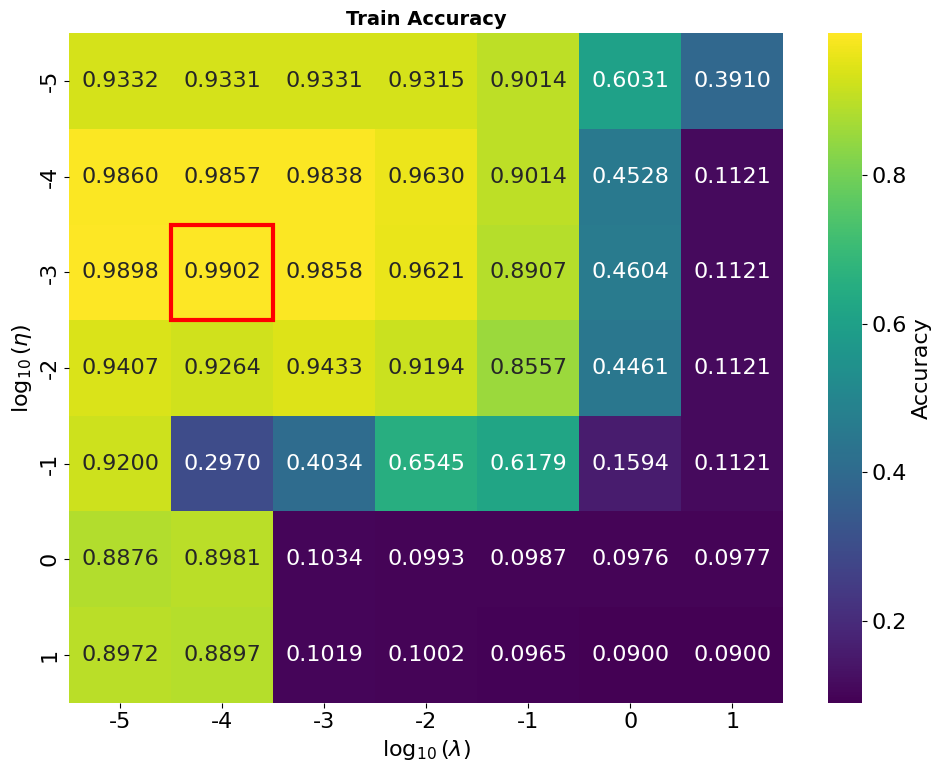

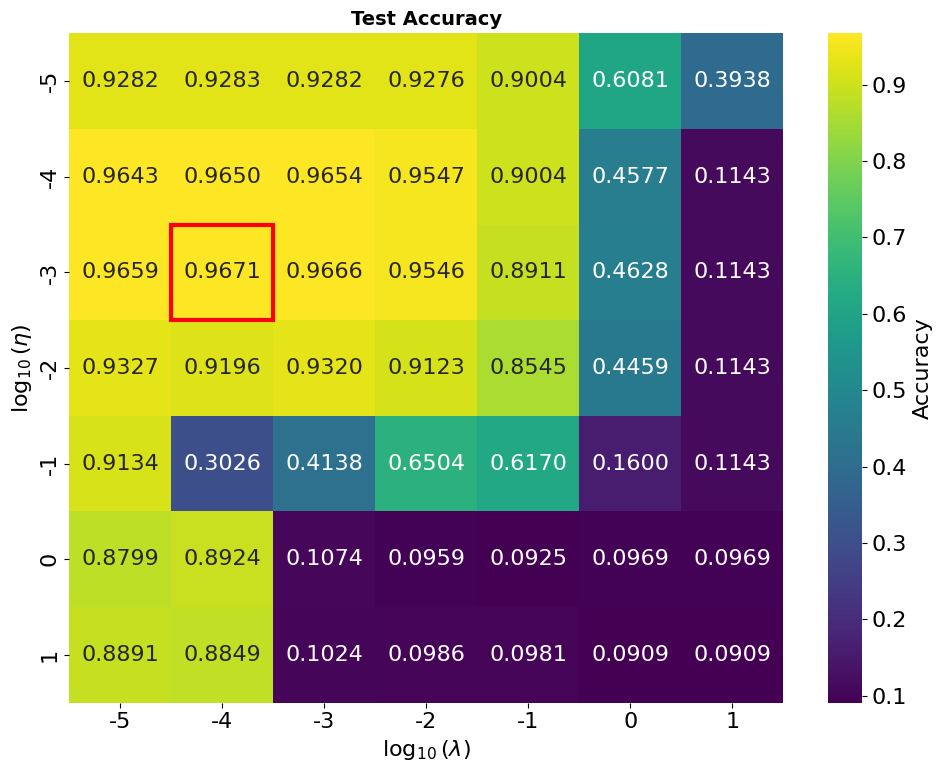

In [6]:
lambda_eta_heatmap(train_acc, eta_vals, lambda_vals,  metric_name='Accuracy', dataset='Train', maximize=True)
plt.show()

lambda_eta_heatmap(test_acc, eta_vals, lambda_vals, metric_name='Accuracy', dataset='Test', maximize=True)
plt.show()

## Parameters for further comparison

In [23]:
LEARNING_RATE = best_eta
LAMBDA_REG = best_lambda

print(f"λ = {LAMBDA_REG}, η = {LEARNING_RATE}")

λ = 0.0001, η = 0.001


# Create NN and train with Adam

In [12]:
model = NeuralNetwork(
    network_input_size=784,
    layer_output_sizes=HIDDEN_LAYERS + [10],
    activations=[ReLU()] * len(HIDDEN_LAYERS) + [Softmax()],
    loss=CrossEntropy(),
    seed=SEED,
    lambda_reg=LAMBDA_REG,
    reg_type='l2',
    weight_init='xavier'
)

optimizer_custom = Adam(eta=LEARNING_RATE)

train(
    nn=model,
    X_train=X_train,
    y_train=y_train_encoded,
    X_val=X_test,
    y_val=y_test_encoded,
    optimizer=optimizer_custom,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    stochastic=True,
    task='classification',
    early_stopping=True,
    patience=PATIENCE,
    verbose=True,
    seed=SEED
)

# Evaluate the model
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

y_train_pred_labels = np.argmax(y_train_pred, axis=1)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

train_acc = accuracy(y_train, y_train_pred_labels)
test_acc = accuracy(y_test, y_test_pred_labels)

print(f"\nTraining Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

[SGD] Epoch   0/20 - Train Loss: 0.2718, Val Loss: 0.1814, Val Acc: 0.9514
Early stopping at epoch 9 (patience=5)

Training Accuracy: 0.9902
Test Accuracy: 0.9671


# Logistic Regression from Scikit-Learn

In [13]:
log_reg_model = LogisticRegression(
    solver=LOGREG_SOLVER,
    multi_class='multinomial',
    max_iter=LOGREG_MAX_ITER,
    random_state=SEED,
    verbose=1
)
log_reg_model.fit(X_train, y_train)
y_pred_logreg = log_reg_model.predict(X_test)
logreg_acc = accuracy_score(y_test, y_pred_logreg)

print(f"\nLogistic Regression Test Accuracy: {logreg_acc:.4f}")

/Users/livestorborg/Desktop/FYS-STK4155/project2/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression Test Accuracy: 0.9156


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s finished


# PyTorch

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Define model
class MNISTNet(nn_torch.Module):
    def __init__(self, hidden_layers):
        super(MNISTNet, self).__init__()
        layers = []
        input_size = 784
        
        # Hidden layers
        for hidden_size in hidden_layers:
            layers.append(nn_torch.Linear(input_size, hidden_size))
            layers.append(nn_torch.ReLU())
            input_size = hidden_size
        
        # Output layer
        layers.append(nn_torch.Linear(input_size, 10))
        
        self.network = nn_torch.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

model_pytorch = MNISTNet(HIDDEN_LAYERS).to(device)
criterion = nn_torch.CrossEntropyLoss()
optimizer_pytorch = optim.Adam(model_pytorch.parameters(), lr=LEARNING_RATE)

# Training loop
for epoch in range(EPOCHS):
    model_pytorch.train()
    running_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        optimizer_pytorch.zero_grad()
        outputs = model_pytorch(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer_pytorch.step()
        running_loss += loss.item()
    
    if (epoch + 1) % 5 == 0:
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")

# Evaluation
model_pytorch.eval()
with torch.no_grad():
    outputs = model_pytorch(X_test_tensor)
    _, y_pred_pytorch = torch.max(outputs, 1)
    y_pred_pytorch = y_pred_pytorch.cpu().numpy()

pytorch_acc = accuracy_score(y_test, y_pred_pytorch)
print(f"\nPyTorch Test Accuracy: {pytorch_acc:.4f}")

Epoch 5/20, Loss: 0.0488
Epoch 10/20, Loss: 0.0179
Epoch 15/20, Loss: 0.0123
Epoch 20/20, Loss: 0.0061

PyTorch Test Accuracy: 0.9684


# Comparing models

In [16]:
print("\n" + "="*60)
print("CLASSIFICATION RESULTS SUMMARY")
print("="*60)
print(f"Our Neural Network Test Accuracy:      {test_acc:.4f}")
print(f"PyTorch Neural Network Test Accuracy:  {pytorch_acc:.4f}")
print(f"Logistic Regression Test Accuracy:     {logreg_acc:.4f}")
print("="*60)


CLASSIFICATION RESULTS SUMMARY
Our Neural Network Test Accuracy:      0.9671
PyTorch Neural Network Test Accuracy:  0.9684
Logistic Regression Test Accuracy:     0.9156
